# Quickstart Example with Multi-class Classification Data
---
This notebook provides an example of conducting OPE of an evaluate policy using multi-class classification data as logged bandit data.

The example consists of the following four major steps:
- (1) Bandit Reduction
- (2) Off-Policy Learning
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

Please see [../examples/multiclass](../multiclass) for a more sophisticated example of the evaluation of OPE with multi-class classification datasets.

In [1]:
# needed when using Google Colab
# !pip install obp

In [2]:
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression

# import open bandit pipeline (obp)
import obp
from obp.dataset import MultiClassToBanditReduction
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)

In [3]:
# obp version
print(obp.__version__)

0.5.4


## (1) Bandit Reduction
`obp.dataset.MultiClassToBanditReduction` is an easy-to-use interface for transforming classification data into logged bandit data.

It takes 
- feature vectors (`X`)
- class labels (`y`)
- classifier to construct behavior policy (`base_classifier_b`)
- paramter to control the entropy of behavior policy (`alpha_b`) 

as inputs and generates logged bandit data that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [4]:
# load raw digits data (multi-class classification data)
# `return_X_y` splits feature vectors and labels, instead of returning a Bunch object
X, y = load_digits(return_X_y=True)

In [5]:
# convert the raw classification data into a logged bandit dataset
# we construct a behavior policy using Logistic Regression and parameter `alpha_b`
# given a pair of a feature vector and a label (x, c), create a pair of a context vector and reward (x, r)
# where r = 1 if the output of the behavior policy is equal to c, and r = 0 otherwise
dataset = MultiClassToBanditReduction(
    X=X,
    y=y,
    base_classifier_b=LogisticRegression(max_iter=10000, random_state=12345),
    alpha_b=0.8,
    dataset_name="digits",
)

please refer to https://zr-obp.readthedocs.io/en/latest/_autosummary/obp.dataset.multiclass.html for the details

In [6]:
# split the original data into training and evaluation sets
dataset.split_train_eval(eval_size=0.7, random_state=12345)

# obtain logged bandit data generated by the behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback(random_state=12345)

the logged bandit data is generated by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}_{i=1}^n$  where $(x,a,r) \sim p(x)\pi_b(a|x)p(r|x,a) $

In [7]:
# `bandit_feedback` is a dictionary storing logged bandit data
bandit_feedback

{'n_actions': 10,
 'n_rounds': 1258,
 'context': array([[ 0.,  0.,  0., ..., 16.,  1.,  0.],
        [ 0.,  0.,  7., ..., 16.,  3.,  0.],
        [ 0.,  0., 12., ...,  8.,  0.,  0.],
        ...,
        [ 0.,  1., 13., ...,  8., 11.,  1.],
        [ 0.,  0., 15., ...,  0.,  0.,  0.],
        [ 0.,  0.,  4., ..., 15.,  3.,  0.]]),
 'action': array([6, 8, 5, ..., 2, 5, 9]),
 'reward': array([1., 1., 1., ..., 1., 1., 1.]),
 'position': None,
 'pi_b': array([[[0.02],
         [0.02],
         [0.02],
         ...,
         [0.02],
         [0.02],
         [0.02]],
 
        [[0.02],
         [0.02],
         [0.02],
         ...,
         [0.02],
         [0.82],
         [0.02]],
 
        [[0.02],
         [0.02],
         [0.02],
         ...,
         [0.02],
         [0.02],
         [0.02]],
 
        ...,
 
        [[0.02],
         [0.02],
         [0.82],
         ...,
         [0.02],
         [0.02],
         [0.02]],
 
        [[0.02],
         [0.02],
         [0.02],
      

## (2) Off-Policy Learning
After generating logged bandit feedback, we now obtain an evaluation policy using the training set. <br>

In [8]:
# obtain action choice probabilities of an evaluation policy
# we construct an evaluation policy using Random Forest and parameter `alpha_e`
action_dist = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForest(random_state=12345),
    alpha_e=0.9,
)

In [9]:
# action_dist is a probability distribution over actions (can be deterministic)
action_dist[:, :, 0]

array([[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.91, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.91, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.91]])

## (3) Off-Policy Evaluation (OPE)
Our next step is OPE, which aims to estimate the performance of evaluation policies using logged bandit data and OPE estimators.

Here, we use 
- `obp.ope.InverseProbabilityWeighting` (IPW)
- `obp.ope.DirectMethod` (DM)
- `obp.ope.DoublyRobust` (DR)

as OPE estimators and visualize the OPE results.

### (3-1) Obtaining a reward estimator
A reward estimator $\hat{q}(x,a)$ is needed for model dependent estimators such as DM or DR.

$\hat{q}(x,a) \approx \mathbb{E} [r \mid x,a]$

In [10]:
# estimate the expected rewards by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    base_model=LogisticRegression(random_state=12345, max_iter=1000),
)

In [11]:
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.

### (3-2) Off-Policy Evaluation
$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_b, \theta)$ using DM, IPW, and DR

In [12]:
# estimate the policy value of the evaluation policy based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

In [13]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval, '\n')

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.886795          0.833408          0.948891
dm   0.787927          0.780838          0.795019
dr   0.882948          0.813345          0.937172 



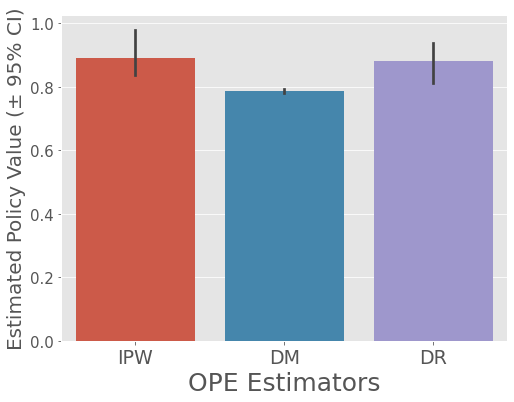

In [14]:
# visualize the policy values of the evaluation policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

## (4) Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

### (4-1) Approximate the Ground-truth Policy Value 
With classification data, we can calculate the ground-truth policy value of the evaluation policies as follows.

$$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{te}|} \sum_{i=1}^{|\mathcal{D}_{te}|} \mathbb{E}_{a \sim \pi_e(a|x_i)} [q(x_i, a)], \; \, where \; \, q(x,a) := \mathbb{E}_{r \sim p(r|x,a)} [r]$$

In [15]:
# calculate the ground-truth performance of the evaluation policy
ground_truth = dataset.calc_ground_truth_policy_value(action_dist=action_dist)

print(f'ground-truth policy value (classification accuracy): {ground_truth}')

ground-truth policy value (classification accuracy): 0.8770906200317964


### (4-2) Evaluation of OPE

We can then evaluate the estimation performance of OPE estimators by comparing the estimated policy values with the ground-truth as follows.

- $\textit{relative-ee} (\hat{V}; \mathcal{D}_b) := \left| \frac{V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b)}{V(\pi_e)} \right|$ (relative estimation error; relative-ee)
- $\textit{SE} (\hat{V}; \mathcal{D}_b) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b) \right)^2$ (squared error; se)

In [16]:
# evaluate the estimation performance of the OPE estimators 
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performances of given estimators 
relative_ee = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth,
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performance of the three estimators (lower means accurate)
relative_ee

,relative-ee
ipw,0.016035
dm,0.101955
dr,0.003644


We can iterate the above process several times to get more reliable results.

Please see [/examples/multiclass](../multiclass) for a more sophisticated example of the evaluation of OPE with multi-class classification data.